Zachary Armand

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import Linear, ReLU, Sequential

In [22]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

In [23]:
input_values = torch.load('input_values.pth')
target_values = torch.load('target_values.pth')

Dataset and dataloaders are used for both models.

In [24]:
# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.85, 0.15])
train_dataset, valid_dataset = random_split(train_dataset, [0.82, 0.18])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")

Train: 69.7%, Test: 15.0%, Valid: 15.3%


# Modeling

In [25]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [26]:
def train_model(model, optimizer, dataloader, device):
    model.train()
    criterion = nn.MSELoss()
    epoch_loss = 0
    for inputs, targets in dataloader:
        # Send to the right device
        inputs, targets = inputs.to(device), targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)[:, 0]
        # Calculate and log loss
        loss = torch.sqrt(criterion(outputs, targets))
        # Backwards pass and step
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*inputs.size(0)  # loss * batch size
    return epoch_loss / len(dataloader.dataset)  # average loss 

def evaluate_model_RSME(model, dataloader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():  # Disable gradients for evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Ensure test inputs are on the same device
            # Make prediction
            outputs = model(inputs)[:, 0]
            # Get loss
            loss = torch.sqrt(criterion(outputs, targets))  # sqrt(MSE)
            total_loss += loss.item()*inputs.size(0)  # loss * batch size
    return total_loss / len(dataloader.dataset)  # average loss

def evaluate_model_MAE(model, dataloader, device):
    model.eval()
    criterion = nn.L1Loss()
    total_loss = 0
    with torch.no_grad():  # Disable gradients for evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Ensure test inputs are on the same device
            # Make prediction
            outputs = model(inputs)[:, 0]
            # Get loss
            loss = criterion(outputs, targets)  # MAE
            total_loss += loss.item()*inputs.size(0)  # loss * batch size
    return total_loss / len(dataloader.dataset)  # average loss

# Simple Linear model

### MLP hyperparameter tuning

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, in_features=12, hidden_features=24, num_layers=3, dropout=0.0):
        super().__init__()
        
        layers = []        
        # Hidden layers (loop to create multiple layers)
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        # Combine all layers into a sequential model
        self.mlpnet = nn.Sequential(
            # Input layer
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            # Loop of layers
            *layers,            
            # Output layer
            nn.Linear(hidden_features, 1),
        )

    def forward(self, x):
        x = self.mlpnet(x)
        return x.squeeze()


In [44]:
# Define hyperparameters to test
testing_params = {
    'batch_size': [32, 64, 128],
    'lr': [0.001, 0.0001, 0.00001],
    'mlp_dropout': [0.0, 0.25, 0.33, 0.5],
    'weight_decay': [0.0, 1e-4, 1e-3, 1e-2]
}

# Create a list of all parameter combinations
param_combinations = [(batch_size, lr, mlp_dropout, weight_decay)
                      for batch_size in testing_params['batch_size']
                      for lr in testing_params['lr']
                      for mlp_dropout in testing_params['mlp_dropout']
                      for weight_decay in testing_params['weight_decay']
                      ]

In [49]:
results = {}

# Initialize tqdm progress bar to track progress through iterations
pbar = tqdm(param_combinations, desc="Training Models", total=len(param_combinations))

num_epochs = 50

# Iterate over parameter combinations
for i, (batch_size, lr, mlp_dropout, weight_decay) in enumerate(pbar):

    # Turn into Dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


    simple_baseball_mlp = SimpleNet(hidden_features=48, num_layers=3, dropout=mlp_dropout).to(DEVICE)
    
    #print(f'Batch size: {batch_size}, hidden size: {hidden_size}, lr: {lr}, dropout: {mlp_dropout}')
    # Print trainable parameters
    trainable_params = sum(p.numel() for p in simple_baseball_mlp.parameters() if p.requires_grad)
    #print(f"Trainable parameters: {trainable_params:,}")

    # Optimizer and loss
    optimizer = Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func = nn.MSELoss()

    # Params: lr, hidden layers, batch size

    # Training
    log = []
    eval_log = []

    # Training loop
    #pbar = tqdm(range(num_epochs), desc="Training MLP")
    #for epoch in pbar:
    for epoch in range(num_epochs):

        # Get average loss over batches for training
        avg_train_loss = train_model(simple_baseball_mlp, optimizer, train_dataloader, DEVICE)
        log.append(avg_train_loss)
        # Validation loss
        avg_valid_loss = evaluate_model_RSME(simple_baseball_mlp, valid_dataloader, DEVICE)
        eval_log.append(avg_valid_loss)
        

        #pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'Train-Valid': (avg_train_loss-avg_valid_loss)})

    results[i] = [log]
    results[i].append(eval_log)

    # Final output
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    test_accuracy_RSME = evaluate_model_RSME(simple_baseball_mlp, test_dataloader, DEVICE)
    test_accuracy_MAE = evaluate_model_MAE(simple_baseball_mlp, test_dataloader, DEVICE)
    results[i].append(test_accuracy_RSME)
    results[i].append(f'Batch size: {batch_size}, lr: {lr}, dropout: {mlp_dropout}, l2: {weight_decay}\nRSME: {test_accuracy_RSME:.4}')

    #print(f'Test RMSE: {test_accuracy_RSME:.4f}, Test MAE: {test_accuracy_MAE:.4f}')

Training Models: 100%|██████████| 144/144 [5:07:02<00:00, 127.94s/it] 


Evaluate the models, first by lowest RSME. Also visualize results to make sure that they aren't overfitting.

6 best models (index and values):
(0, 'Batch size: 32, lr: 0.001, dropout: 0.0, l2: 0.0\nRSME: 0.3505')
(48, 'Batch size: 64, lr: 0.001, dropout: 0.0, l2: 0.0\nRSME: 0.3535')
(16, 'Batch size: 32, lr: 0.0001, dropout: 0.0, l2: 0.0\nRSME: 0.3541')
(64, 'Batch size: 64, lr: 0.0001, dropout: 0.0, l2: 0.0\nRSME: 0.3573')
(49, 'Batch size: 64, lr: 0.001, dropout: 0.0, l2: 0.0001\nRSME: 0.3577')
(96, 'Batch size: 128, lr: 0.001, dropout: 0.0, l2: 0.0\nRSME: 0.3581')


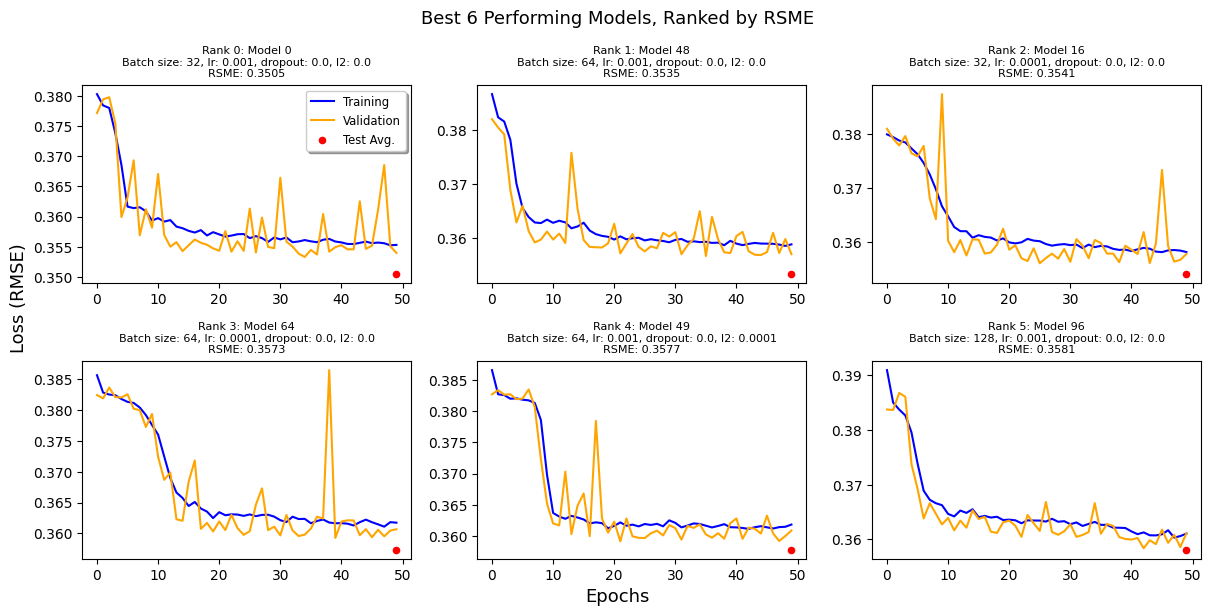

In [50]:
def evaluate_results(results, n_best=6):
    # Get rankings of each model by RSME
    mlp_rsmes = np.array([results[i][2] for i in results])
    order = mlp_rsmes.argsort()
    # Then, pull out the top n models and print their information
    n_best = 6
    best_models = [(ind.item(), results[ind][3]) for ind in order[0:n_best]]
    # Print out index of model in results dictionary and it's parameters
    print(f'{n_best} best models (index and values):')
    for m in best_models:
        print(m)

    ### Plot n best results
    n_columns = 3
    n_rows = int(np.ceil(n_best / n_columns))
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns * 4, n_rows * 3))
    axes = axes.flatten()

    for i, model in enumerate(order[0:n_best]):
        axes[i].set_title(f'Rank {i}: Model {order[i]}\n{results[model][3]}', size=8)
        axes[i].plot(results[model][0], c='b', label='Training')
        axes[i].plot(results[model][1], c='orange', label='Validation')
        axes[i].scatter(x=len(results[i][1])-1, y=results[model][2], c='r', s=20, label='Test Avg.')
        if i == 0: axes[i].legend(loc='upper right', fontsize='small', shadow=True)  # only show legend for first plot
    fig.text(0.001, 0.5, 'Loss (RMSE)', ha='center', va='center', rotation='vertical', fontsize=13)
    fig.text(0.5, 0.001, 'Epochs', ha='center', va='center', fontsize=13)
    plt.suptitle(f"Best {n_best} Performing Models, Ranked by RSME", fontsize=13)
    plt.tight_layout()

    return None

evaluate_results(results, n_best=6)

In [ ]:
def visualize_all_models(results):
    n_figures = len(results)
    n_columns = 3
    n_rows = int(np.ceil(n_figures / n_columns))
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns * 4, n_rows * 3))
    axes = axes.flatten()

    for i in range(n_figures):
        axes[i].set_title(f'Model {i}\n{results[i][3]}', size=8)
        axes[i].plot(results[i][0], c='b')
        axes[i].plot(results[i][1], c='orange')
        axes[i].scatter(x=num_epochs-1, y=results[i][2], c='b', s=20)
    for j in range(n_figures, len(axes)):
        axes[j].axis('off')
    plt.suptitle("All Evaluated Models")
    fig.text(0.001, 0.5, 'Loss (RMSE)', ha='center', va='center', rotation='vertical', fontsize=13)
    fig.text(0.5, 0.001, 'Epochs', ha='center', va='center', fontsize=13)
    plt.tight_layout()

visualize_all_models(results)

A little bit of fine-tuning. Mostly just training to decide the optimal batch size. Take the top performing metrics, and then tune these hyperparameters, but this time with more training epochs. From this, choose the best hyperparameters to use in the final model. 

In [76]:
# Define hyperparameters to test
testing_params = {
    'batch_size': [32, 64, 256],
    'lr': [0.001],
    'mlp_dropout': [0.0],
    'weight_decay': [0.0]
}

# Create a list of all parameter combinations
param_combinations = [(batch_size, lr, mlp_dropout, weight_decay)
                      for batch_size in testing_params['batch_size']
                      for lr in testing_params['lr']
                      for mlp_dropout in testing_params['mlp_dropout']
                      for weight_decay in testing_params['weight_decay']
                      ]

results_mlp2 = {}

# Initialize tqdm progress bar to track progress through iterations
pbar = tqdm(param_combinations, desc="Training Models", total=len(param_combinations))

num_epochs = 150

# Iterate over parameter combinations
for i, (batch_size, lr, mlp_dropout, weight_decay) in enumerate(pbar):

    # Turn into Dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    # Set up model with hyperparameters
    simple_baseball_mlp = SimpleNet(hidden_features=48, num_layers=3, dropout=mlp_dropout).to(DEVICE)
    
    # Optimizer and loss
    optimizer = Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func = nn.MSELoss()

    # Training
    log = []
    eval_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Get average loss over batches for training
        avg_train_loss = train_model(simple_baseball_mlp, optimizer, train_dataloader, DEVICE)
        log.append(avg_train_loss)
        # Validation loss
        avg_valid_loss = evaluate_model_RSME(simple_baseball_mlp, valid_dataloader, DEVICE)
        eval_log.append(avg_valid_loss)
        
    results_mlp2[i] = [log]
    results_mlp2[i].append(eval_log)

    # Final output
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    test_accuracy_RSME = evaluate_model_RSME(simple_baseball_mlp, test_dataloader, DEVICE)
    test_accuracy_MAE = evaluate_model_MAE(simple_baseball_mlp, test_dataloader, DEVICE)
    results_mlp2[i].append(test_accuracy_RSME)
    results_mlp2[i].append(f'Batch size: {batch_size}, lr: {lr}, dropout: {mlp_dropout}, l2: {weight_decay}\nRSME: {test_accuracy_RSME:.4}')

Training Models: 100%|██████████| 3/3 [20:10<00:00, 403.34s/it]


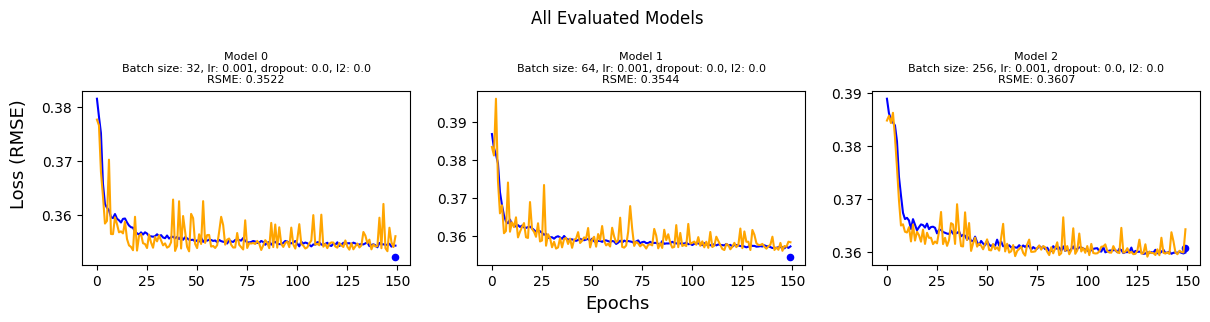

In [77]:
visualize_all_models(results_mlp2)

In [144]:
print(f"Batch size 32 validation loss variance: {np.var(np.array(results_mlp2[0][1])):.6f}")
print(f"Batch size 64 validation loss variance: {np.var(np.array(results_mlp2[1][1])):.6f}")

Batch size 32 validation loss variance: 0.000013
Batch size 64 validation loss variance: 0.000026


### MLP Final Results

After hyperparameter tuning, the linear network hyperparameters are:
- Batch size: 64
- Learning rate: 0.001
- Dropout: 0.0
- L2 weight decay: 0.0

Batch size of 64, while slightly higher RSME than 32, appeared to have a more stable training. The variation of the loss is lower, and the plot of the validatoin set has fewer spikes.
This is somewhat interesting, as the models with some regularization (dropout, weight decay) performed less well than the models with none. 

# RNN Network

A many-to-one RNN using gated recurrence units (GRUs)

In [293]:
class BaseballRNN_test(torch.nn.Module):
    def __init__(self, input_size, output_size=1, hidden_size=256, n_layers=1, bidirectional=False, hidden_init='rand', rnn_dropout=0.2):
        super().__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.hidden_init = hidden_init
        self.rnn_dropout = rnn_dropout


        # Input fc layer
        self.fc_in = nn.Linear(input_size, self.hidden_size)
        # GRU Layer
        self.rnn1 = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True, num_layers=self.n_layers, dropout=self.rnn_dropout)
        # Dropout layer after last GRU layer
        self.layernorm = nn.LayerNorm(self.hidden_size)
        self.dropout = nn.Dropout(self.rnn_dropout)
        # Fully connected layer
        self.fc1 = nn.Linear(self.hidden_size, 64)  # fixed number of neurons in the linear layer
        # Output layer
        self.fc_out = nn.Linear(64, output_size) 
        
        # RELU
        self.relu = nn.ReLU()

    def _init_hidden(self, batch_size, device):
        """Initialize the hidden state for the GRU."""
        if self.hidden_init == 'zero':
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        elif self.hidden_init == 'rand':
            h0 = torch.randn(self.n_layers, batch_size, self.hidden_size, device=device)
        elif self.hidden_init == 'xavier':
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
            nn.init.xavier_uniform_(h0)
        else:
            raise ValueError(f"Unsupported hidden_init: {self.hidden_init}")
        return h0

    def forward(self, x):      
        # Initial hidden states for RNNs
        h0 = self._init_hidden(x.size(0), x.device)

        # Pre RNN Linear Layer
        x = self.relu(self.fc_in(x))

        # Send through RNN 
        residual = x
        out, hidden = self.rnn1(x, h0)
        out = out + residual  # Residual connection
        # Get output of the last time step
        out = out[:, -1, :]  # (batch_size, seq_len, hidden_size)
        out = self.layernorm(out)
        out = self.dropout(out)

        # Send through fully connected layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out)

        # Output layer
        out = self.fc_out(out)

        return out

In [294]:
# Define hyperparameters to test
testing_params = {
    'batch_size': [32, 64, 256],
    'n_layers': [1, 2],
    'lr': [0.001, 0.0001],
    'rnn_dropout': [0.0, 0.25, 0.5],
    'weight_decay': [0.0, 1e-4, 1e-2],
}

# Create a list of all parameter combinations
param_combinations = [(batch_size, n_layers, lr, rnn_dropout, weight_decay)
                      for batch_size in testing_params['batch_size']
                      for n_layers in testing_params['n_layers']
                      for lr in testing_params['lr']
                      for rnn_dropout in testing_params['rnn_dropout']
                      for weight_decay in testing_params['weight_decay']
                      ]

In [ ]:
results_rnn = {}

# Initialize tqdm progress bar to track progress through 144 iterations
pbar = tqdm(param_combinations, desc="Training Models", total=len(param_combinations))

num_epochs = 50

# Iterate over parameter combinations
for i, (batch_size, n_layers, lr, rnn_dropout, weight_decay) in enumerate(pbar):

    # Turn into Dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    input_size = train_dataloader.dataset[0][0].size()[1]
    baseball_rnn = BaseballRNN_test(input_size=input_size, output_size=1, hidden_size=36,
                                    n_layers=n_layers, hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

    # Optimizer and loss
    optimizer = Adam(baseball_rnn.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func = nn.MSELoss()

    # Training
    log = []
    eval_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Get average loss over batches for training
        avg_train_loss = train_model(baseball_rnn, optimizer, train_dataloader, DEVICE)
        log.append(avg_train_loss)
        # Validation loss
        avg_valid_loss = evaluate_model_RSME(baseball_rnn, valid_dataloader, DEVICE)
        eval_log.append(avg_valid_loss)

    results_rnn[i] = [log] 
    results_rnn[i].append(eval_log)

    # Final output
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    test_accuracy_RSME = evaluate_model_RSME(baseball_rnn, test_dataloader, DEVICE)
    test_accuracy_MAE = evaluate_model_MAE(baseball_rnn, test_dataloader, DEVICE)
    results_rnn[i].append(test_accuracy_RSME)
    results_rnn[i].append(f'Batch size: {batch_size}, n_layers: {n_layers}, lr: {lr}, dropout: {rnn_dropout}, l2: {weight_decay}\nRSME: {test_accuracy_RSME:.4}')

Training Models: 100%|██████████| 108/108 [3:41:27<00:00, 123.03s/it] 


6 best models (index and values):
(25, 'Batch size: 32, n_layers: 2, lr: 0.001, dropout: 0.5, l2: 0.0001\nRSME: 0.3724')
(18, 'Batch size: 32, n_layers: 2, lr: 0.001, dropout: 0.0, l2: 0.0\nRSME: 0.3729')
(28, 'Batch size: 32, n_layers: 2, lr: 0.0001, dropout: 0.0, l2: 0.0001\nRSME: 0.3729')
(21, 'Batch size: 32, n_layers: 2, lr: 0.001, dropout: 0.25, l2: 0.0\nRSME: 0.3729')
(3, 'Batch size: 32, n_layers: 1, lr: 0.001, dropout: 0.25, l2: 0.0\nRSME: 0.373')
(33, 'Batch size: 32, n_layers: 2, lr: 0.0001, dropout: 0.5, l2: 0.0\nRSME: 0.3731')


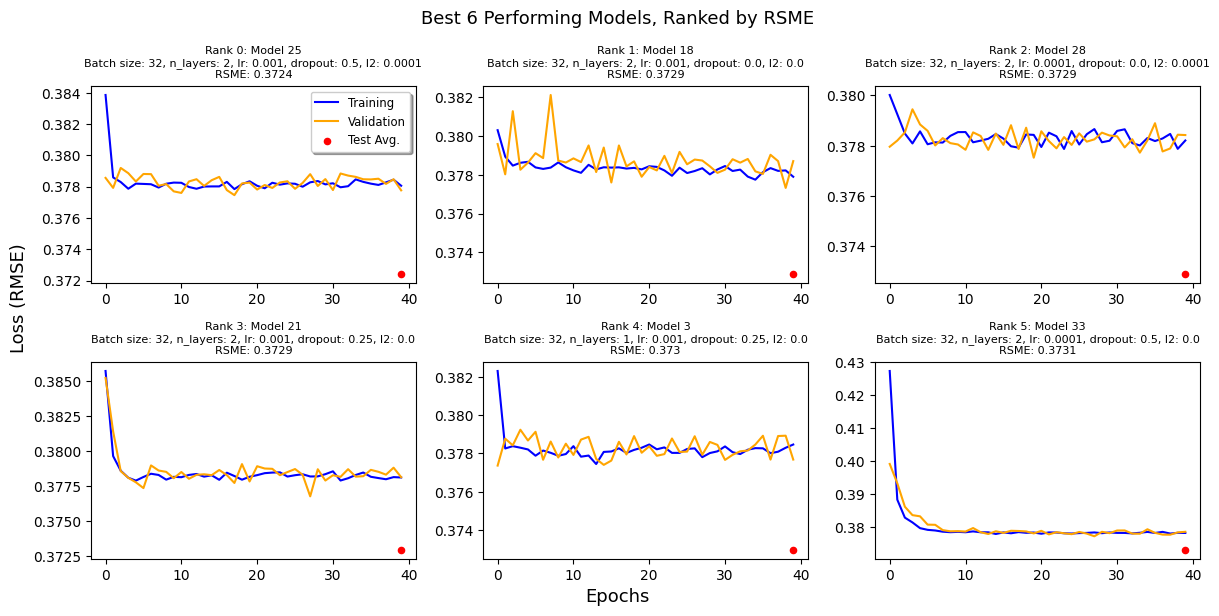

In [298]:
evaluate_results(results_rnn, n_best=6)

Showing effect of dropout on final model performance

In [314]:
# Initialize the model and move it to the appropriate device
dropout_tests = [0.0, 0.2, 0.3, 0.4, 0.5]
dropout_losses = {dp: [[], []] for dp in dropout_tests}

num_epochs = 75

for rnn_dropout in dropout_tests:

    # Initialize model
    input_size = train_dataloader.dataset[0][0].size()[1]
    RNN_model = BaseballRNN_test(input_size=input_size, output_size=1, hidden_size=64, 
                                 n_layers=2, hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(RNN_model.parameters(), lr=0.0001)

    # Training loop
    log = []
    eval_log = []

    # Training loop
    pbar = tqdm(range(num_epochs), desc=f"Training RNN ({rnn_dropout})")
    for epoch in pbar:

        # Get average loss over batches for training
        avg_train_loss = train_model(RNN_model, optimizer, train_dataloader, DEVICE)
        #log.append(avg_train_loss)
        avg_valid_loss = evaluate_model_RSME(RNN_model, valid_dataloader, DEVICE)
        #eval_log.append(avg_valid_loss)
        dropout_losses[rnn_dropout][0].append(avg_train_loss)
        dropout_losses[rnn_dropout][1].append(avg_valid_loss)

        pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})


Training RNN (0.5): 100%|██████████| 75/75 [01:22<00:00,  1.10s/it, Train loss=0.385, Validation loss=0.386]


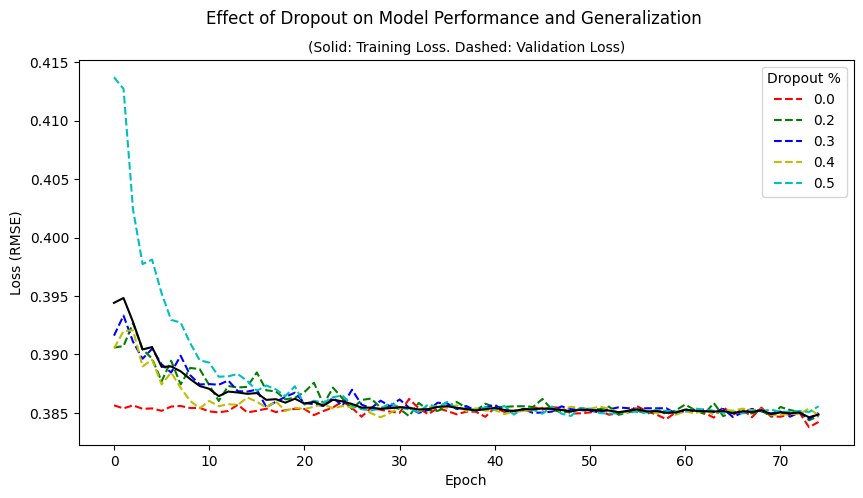

In [315]:
# Plot loss over time
plt.figure(figsize=(10, 5))
plt.suptitle(f'Effect of Dropout on Model Performance and Generalization', fontsize=12)
plt.title(f'(Solid: Training Loss. Dashed: Validation Loss)', fontsize=10)
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
colors = ['r', 'g', 'b', 'y', 'c']
for i, dp in enumerate(dropout_tests):
    #plt.plot(dropout_losses[dp][0], label=dp, linestyle='solid')
    plt.plot(dropout_losses[dp][1], linestyle='dashed', c=colors[i], label=dp)
plt.plot(np.array([dropout_losses[dl][1] for dl in dropout_losses]).mean(axis=0), color='black')
plt.legend(title='Dropout %', loc='upper right')

plt.show()